In [2]:
import os, sys
import timeit
from IPython.display import display

import pandas as pd
from matplotlib import pyplot as plt
import seaborn

pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


## Import Data

In [2]:
census_df = pd.read_csv('DATA/CHI_CommAreas_Census2010.csv', skiprows=1)

census_df.head(10)

,Geog,GeogKey,Total Population,"Not Hispanic or Latino, White alone","Not Hispanic or Latino, Black or African American alone","Not Hispanic or Latino, American Indian and Alaska Native alone","Not Hispanic or Latino, Asian alone","Not Hispanic or Latino, Native Hawaiian and Other Pacific Islander alone","Not Hispanic or Latino, Some Other Race alone","Not Hispanic or Latino, Two or More Races",...,Median Age,Total Households,Average Household Size,Total Housing Units,Occupied Housing Units,Vacant Housing Units,Occupied Housing Units.1,Owned with a mortgage or a loan,Owned free and clear,Renter occupied
0,Rogers Park,1,54991,21618,14461,142,3523,39,202,1573,...,32.400,24292,2.130,27564,24292,3272,24292,6128,1009,17155
1,West Ridge,2,71942,30706,8015,189,16184,3,225,1919,...,35.100,24755,2.850,27466,24755,2711,24755,8829,3367,12559
2,Uptown,3,56362,29098,11275,191,6414,10,130,1235,...,35.500,29719,1.790,32541,29719,2822,29719,8298,1230,20191
3,Lincoln Square,4,39493,24916,1488,72,4399,11,128,917,...,33.500,18194,2.140,19906,18194,1712,18194,5482,1406,11306
4,North Center,5,31867,24634,738,55,1449,16,51,594,...,32.500,14561,2.180,16197,14561,1636,14561,5805,1147,7609
5,Lake View,6,94368,75845,3651,110,5653,44,140,1727,...,30.400,54425,1.720,59529,54425,5104,54425,16640,3488,34297
6,Lincoln Park,7,64116,53138,2753,54,3296,17,116,1171,...,28.900,33536,1.800,36864,33536,3328,33536,11409,2963,19164
7,Near North Side,8,80484,58033,8732,79,8140,25,163,1338,...,35.200,51714,1.520,62364,51714,10650,51714,17237,5991,28486
8,Edison Park,9,11187,9885,29,3,269,1,8,120,...,41.400,4726,2.370,4964,4726,238,4726,2478,1186,1062
9,Norwood Park,10,37023,30157,164,54,1696,1,38,471,...,43.000,14937,2.440,15848,14937,911,14937,7758,4009,3170


## Extract Data

In [3]:
def extract_fct():
    global race_df
    race_df = census_df.filter(regex='Geog|Hispanic', axis=1)
    
    global age_df
    age_df = census_df.filter(regex='Geog|years', axis=1)
      
    global gender_df
    gender_df = census_df.filter(regex='Geog|Total|Male|Female', axis=1)
      
    global educ_df
    educ_df = pd.read_csv('DATA/CHI_CommAreas_Educ2010.csv')\
                 .filter(regex='Geog|Total', axis=1)
      
    global hhold_df
    hhold_df = census_df.filter(regex='Geog|Household', axis=1)
      
    global housing_df
    housing_df = census_df.filter(regex='Geog|Total\\.Housing|Occupied|Vacant', axis=1)\
                                .drop(['Occupied Housing Units.1'], axis=1) 
    
    global occupied_df
    occupied_df = census_df.filter(regex='Geog|Owned|Renter', axis=1)

extract_fct()

## Reshape Data

In [4]:
def reshape_fct():
    # RACE
    global race_long_df
    race_long_df = race_df.melt(id_vars=['Geog', 'GeogKey'], var_name='Race_Ethnicity', value_name='Population')
    
    
    # AGE
    global age_long_df
    age_df[[i.replace('Male', 'Age') for i in age_df.columns if "Male" in i]] = \
                  age_df.filter(regex="Male", axis=1).\
                      rename(columns={i:i.replace('Male', 'Age') for i in age_df.columns if "Male" in i}) + \
                  age_df.filter(regex="Female", axis=1).\
                      rename(columns={i:i.replace('Female', 'Age') for i in age_df.columns if "Female" in i})
    
    
    age_long_df = age_df.filter(regex="Geog|Age", axis=1).melt(id_vars=['Geog', 'GeogKey'], 
                                                               var_name='Age_Group', value_name='Population')
    
    # GENDER
    global gender_long_df
    gender_df["male"] = gender_df.filter(regex="Male", axis=1).apply(sum, axis=1)
    gender_df["female"] = gender_df.filter(regex="Female", axis=1).apply(sum, axis=1)
    
    gender_long_df = gender_df.filter(regex='Geog|(^male)|female', axis=1).\
                               melt(id_vars=['Geog', 'GeogKey'], var_name='Gender', value_name='Population')
    
    
    # EDUCATION
    global educ_long_df
    educ_long_df = educ_df.melt(id_vars=['Geog', 'GeogKey'], var_name='Education_Level', value_name='Population')
    
    
    # HOUSEHOLDS
    global hholds_long_df
    hholds_long_df = hhold_df
    
    
    # HOUSING
    global housing_long_df
    housing_long_df = housing_df.melt(id_vars=['Geog', 'GeogKey'], var_name='Occupied_Status', value_name='Housing_Units')
    
    # OCCUPIED
    global occupied_long_df
    occupied_long_df = occupied_df.melt(id_vars=['Geog', 'GeogKey'], var_name='Occupied_Type', value_name='Housing_Units')
    
reshape_fct()

## Summarize Data

In [5]:

def summarize_fct():
    # COMM_AREA
    comm_agg_ser = census_df['Total Population'].agg({'mean', 'median', 'min', 'max', 'sum'}).to_frame()
                                       
    
    # RACE
    race_agg_df = race_long_df.groupby('Race_Ethnicity')['Population']\
                                       .agg({'mean', 'median', 'min', 'max', 'sum'})
                                       
    race_agg_df = race_agg_df.rename(columns={col:col+'_population' for col in race_agg_df.columns})
    
    # AGE
    age_agg_df = age_long_df.groupby('Age_Group')['Population']\
                                     .agg({'mean', 'median', 'min', 'max', 'sum'})
                                       
    age_agg_df = age_agg_df.rename(columns={col:col+'_population' for col in age_agg_df.columns})
    
    
    # GENDER
    gender_agg_df = gender_long_df.groupby('Gender')['Population']\
                                           .agg({'mean', 'median', 'min', 'max', 'sum'})
                                       
    gender_agg_df = gender_agg_df.rename(columns={col:col+'_population' for col in gender_agg_df.columns})
    
    
    # EDUCATION
    educ_agg_df = educ_long_df.groupby('Education_Level')['Population']\
                                       .agg({'mean', 'median', 'min', 'max', 'sum'})
                                       
    educ_agg_df = educ_agg_df.rename(columns={col:col+'_population' for col in educ_agg_df.columns})
    
    
    # HOUSEHOLDS
    hholds_agg_ser = hholds_long_df['Total Households'].agg({'mean', 'median', 'min', 'max', 'sum'}).to_frame()
                                               
    # HOUSING
    housing_agg_df = housing_long_df.groupby('Occupied_Status')['Housing_Units']\
                                       .agg({'mean', 'median', 'min', 'max', 'sum'})
                                       
    housing_agg_df = housing_agg_df.rename(columns={col:col+'_housing_units' for col in housing_agg_df.columns})
    
    # OCCUPIED
    occupied_agg_df = occupied_long_df.groupby('Occupied_Type')['Housing_Units']\
                                       .agg({'mean', 'median', 'min', 'max', 'sum'})
                                       
    occupied_agg_df = occupied_agg_df.rename(columns={col:col+'_occupied_units' for col in occupied_agg_df.columns})
    
    return comm_agg_ser, race_agg_df, age_agg_df, gender_agg_df, educ_agg_df, hholds_agg_ser, housing_agg_df, occupied_agg_df
    
for i in summarize_fct():
    display(i)

,Total Population
sum,2695598.000
min,2876.000
max,98514.000
median,31028.000
mean,35007.766


,sum_population,min_population,max_population,median_population,mean_population
Race_Ethnicity,,,,,
Hispanic or Latino,778862,20,65457,4442,10115.091
"Not Hispanic or Latino, American Indian and Alaska Native alone",4097,0,191,41,53.208
"Not Hispanic or Latino, Asian alone",144903,0,16184,294,1881.857
"Not Hispanic or Latino, Black or African American alone",872286,29,83837,6122,11328.390
"Not Hispanic or Latino, Native Hawaiian and Other Pacific Islander alone",557,0,44,3,7.234
"Not Hispanic or Latino, Some Other Race alone",4227,0,225,30,54.896
"Not Hispanic or Latino, Two or More Races",35949,26,1919,321,466.870
"Not Hispanic or Latino, White alone",854717,19,75845,4364,11100.221


,sum_population,min_population,max_population,median_population,mean_population
Age_Group,,,,,
Age: 10 to 14 years,164466,192,7547,1688,2135.922
Age: 15 to 17 years,105200,147,5274,1182,1366.234
Age: 18 and 19 years,77733,85,3358,820,1009.519
Age: 20 years,41071,27,1659,451,533.390
Age: 21 years,40138,34,1584,439,521.273
Age: 22 to 24 years,141818,89,10765,1327,1841.792
Age: 25 to 29 years,276139,156,23641,2163,3586.221
Age: 30 to 34 years,239412,161,13779,1991,3109.247
Age: 35 to 39 years,200508,161,8360,1939,2604.000


,sum_population,min_population,max_population,median_population,mean_population
Gender,,,,,
female,1387526,1485,53325,16310,18019.818
male,1308072,1286,47000,14245,16987.948


,sum_population,min_population,max_population,median_population,mean_population
Education_Level,,,,,
Total 25 years and over,1768053,1923,73883,19210,22961.727
Total Bachelor's degree or higher,570134,151,56014,3975,7404.338
"Total High school graduate, GED, or alternative",422571,564,21123,4807,5487.935
Total Less than high school diploma,364425,407,23697,3638,4732.792
Total Population,2695598,2876,98514,31028,35007.766
Total Some college or associate's degree,410923,554,18011,4383,5336.662


,Total Households
sum,1045560.000
min,1077.000
max,54425.000
median,11064.000
mean,13578.701


,sum_housing_units,min_housing_units,max_housing_units,median_housing_units,mean_housing_units
Occupied_Status,,,,,
Occupied Housing Units,1045560,1077,54425,11064,13578.701
Vacant Housing Units,148777,170,10650,1712,1932.169


,sum_occupied_units,min_occupied_units,max_occupied_units,median_occupied_units,mean_occupied_units
Occupied_Type,,,,,
Owned free and clear,111147,27,5991,1275,1443.468
Owned with a mortgage or a loan,358415,159,17237,4114,4654.740
Renter occupied,575998,524,34297,6288,7480.494


## Graphing Data

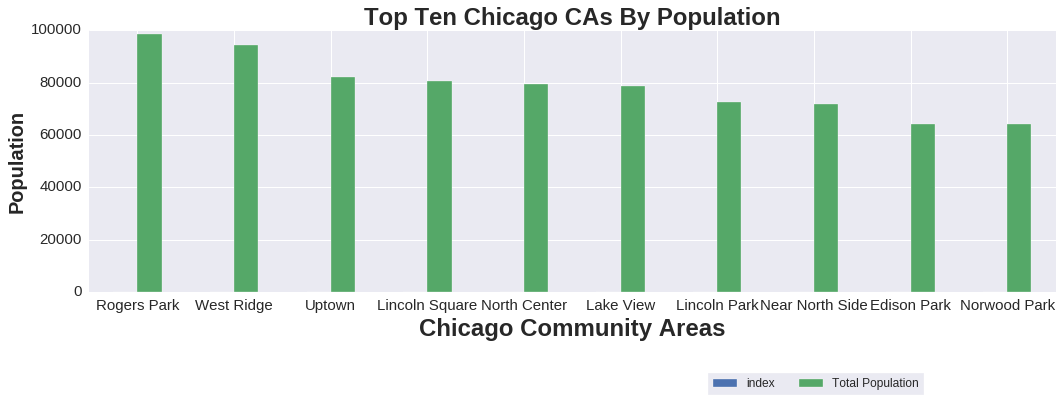

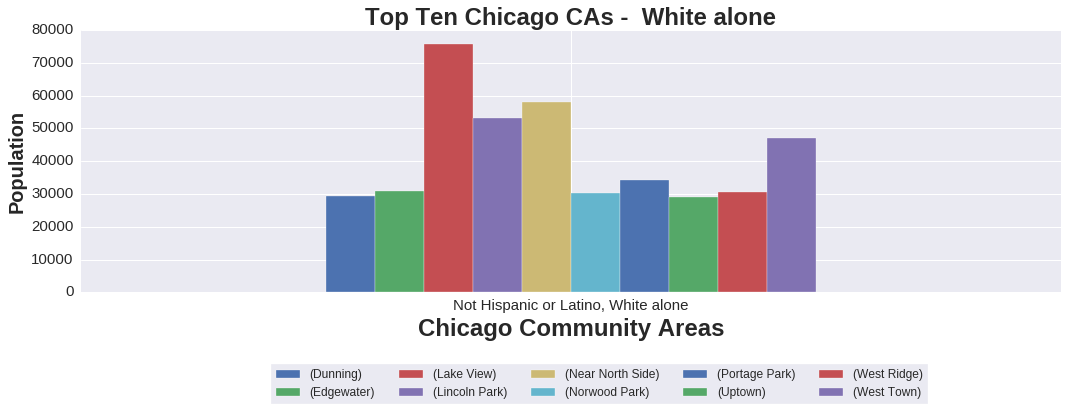

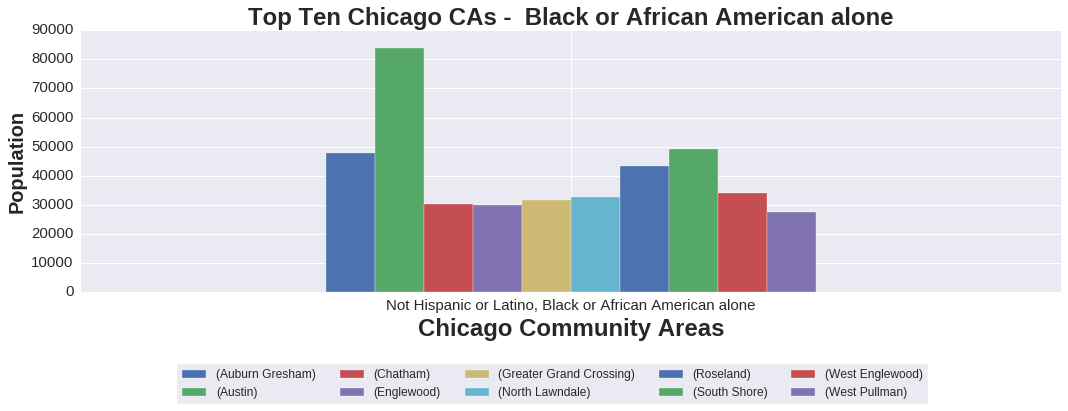

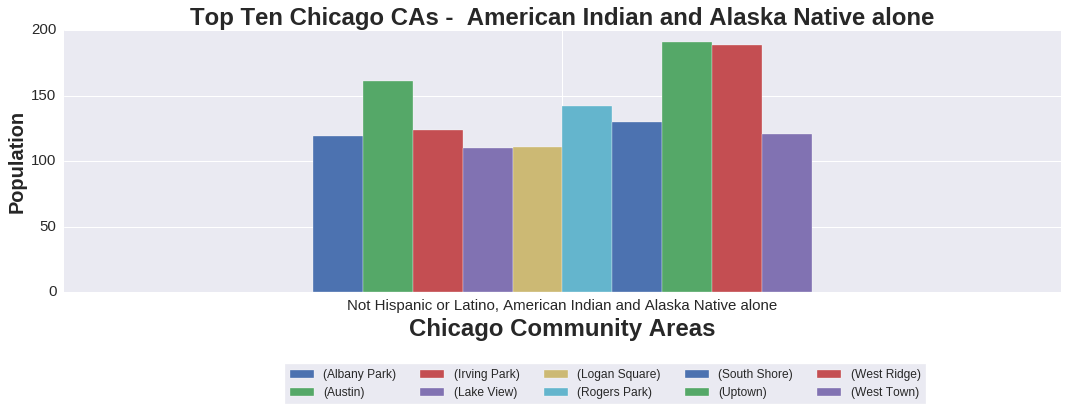

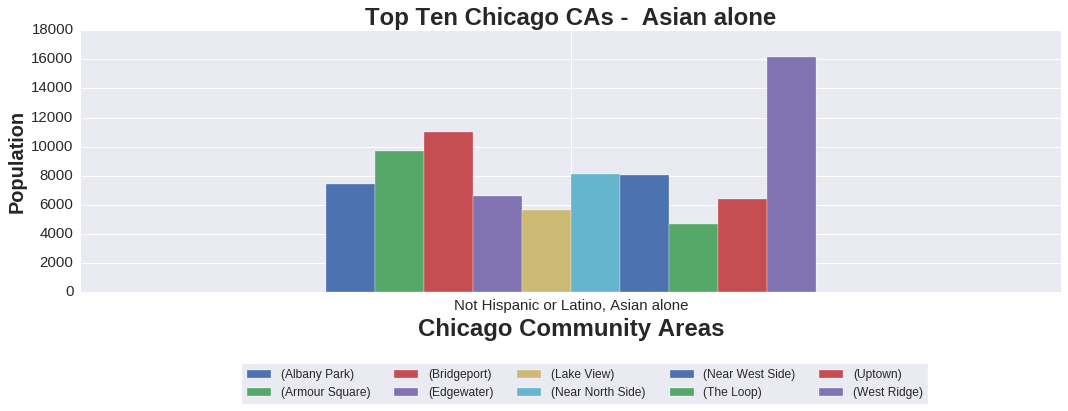

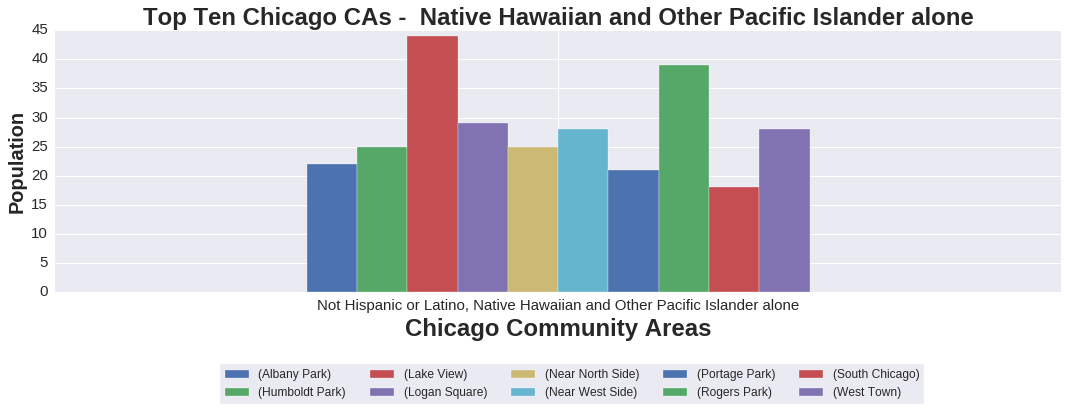

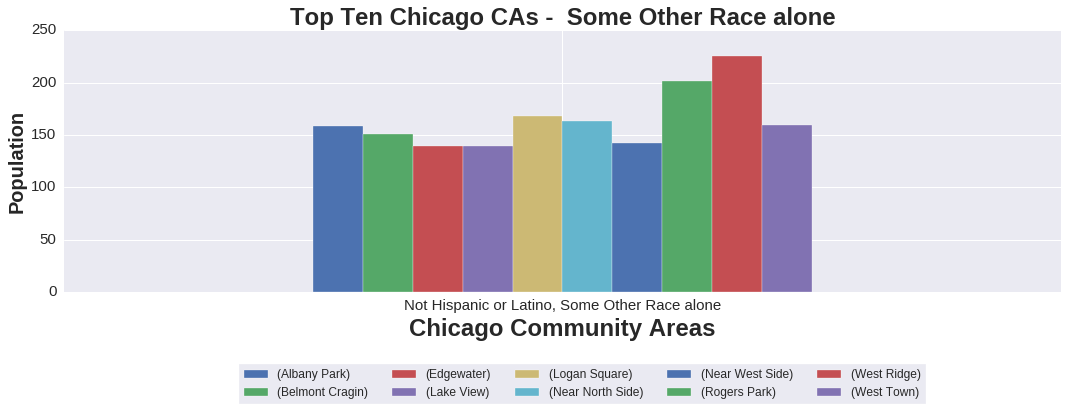

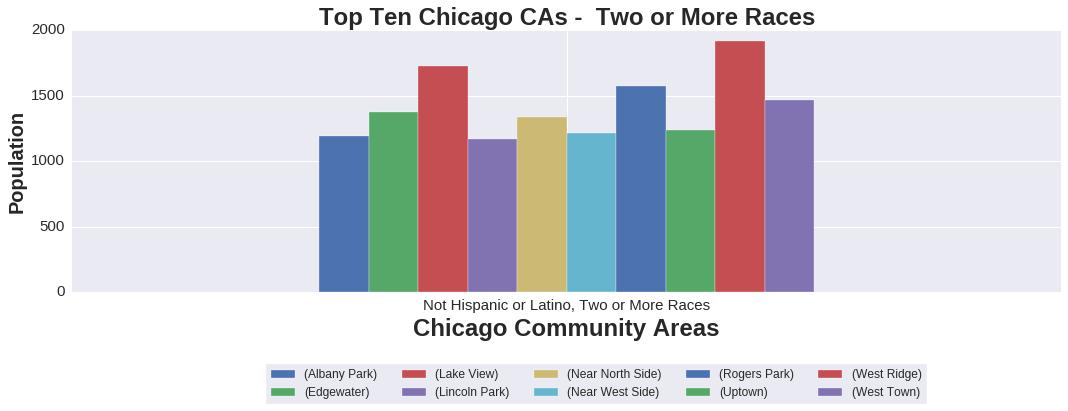

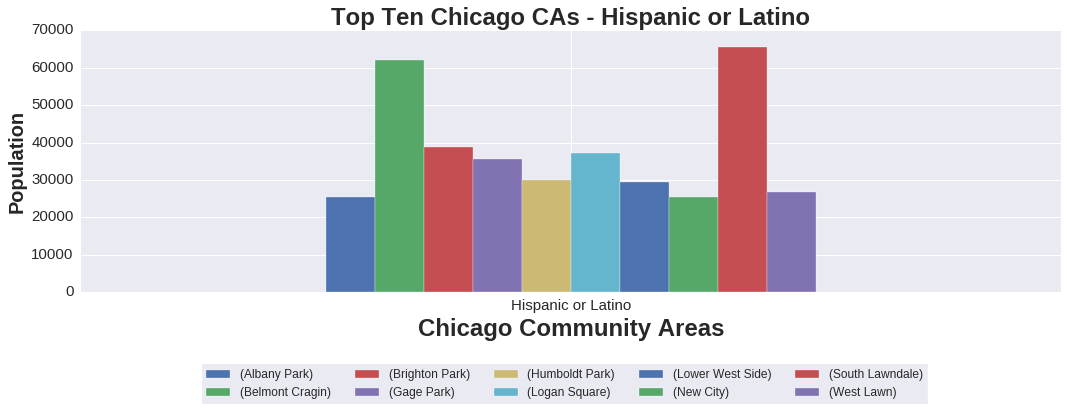

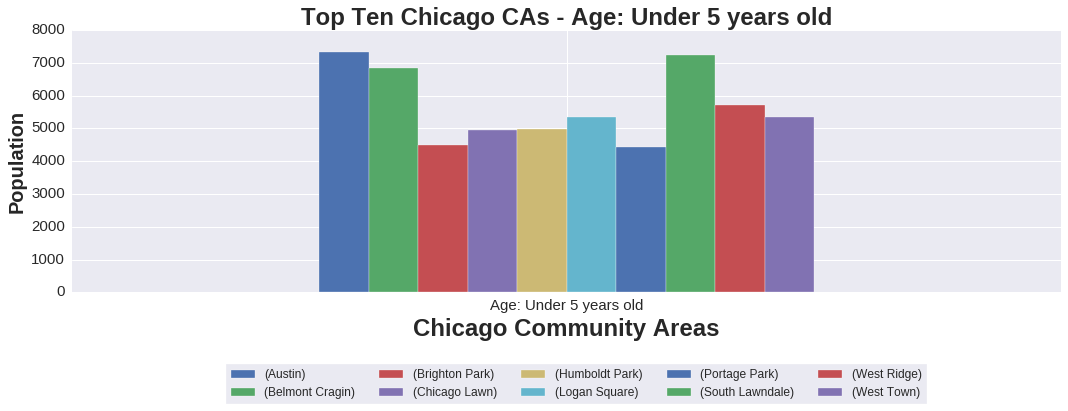

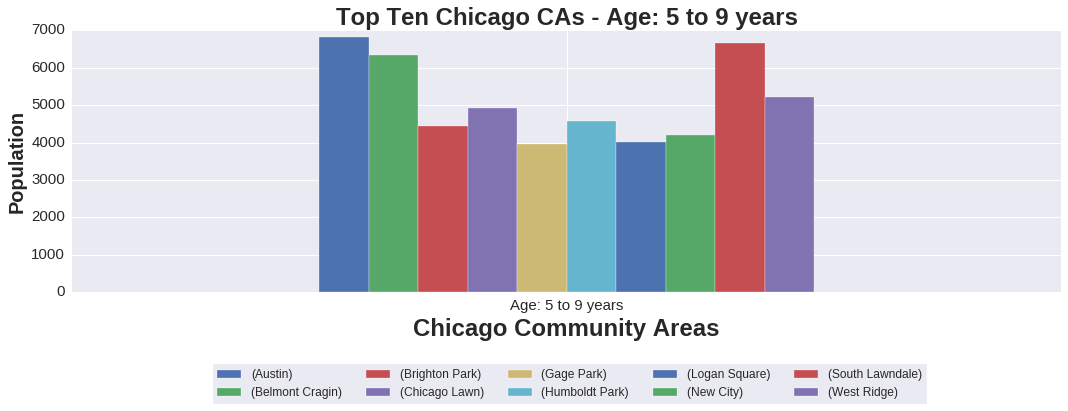

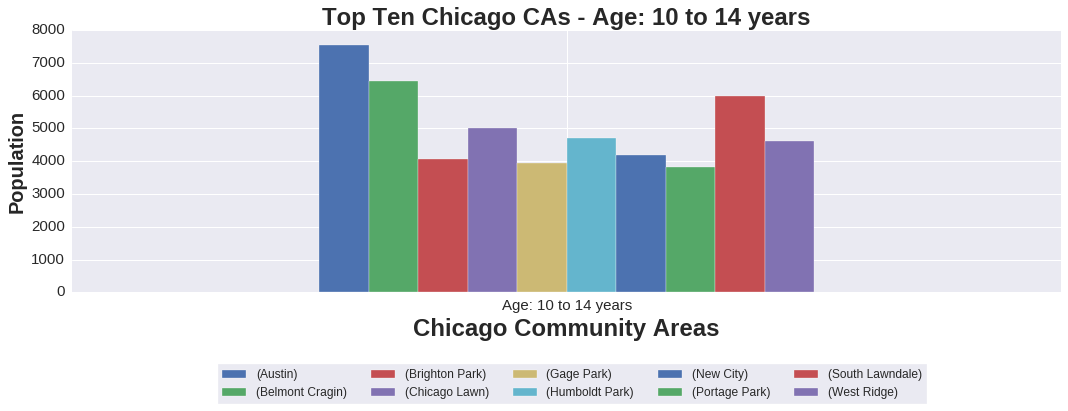

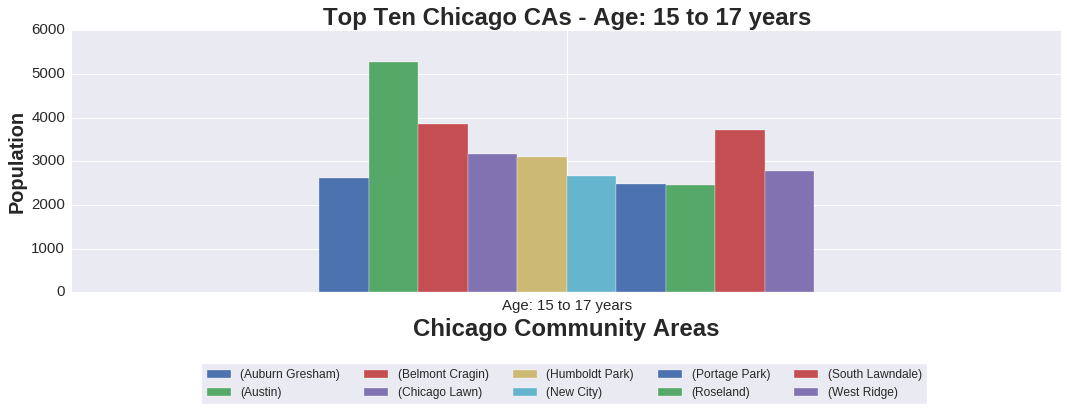

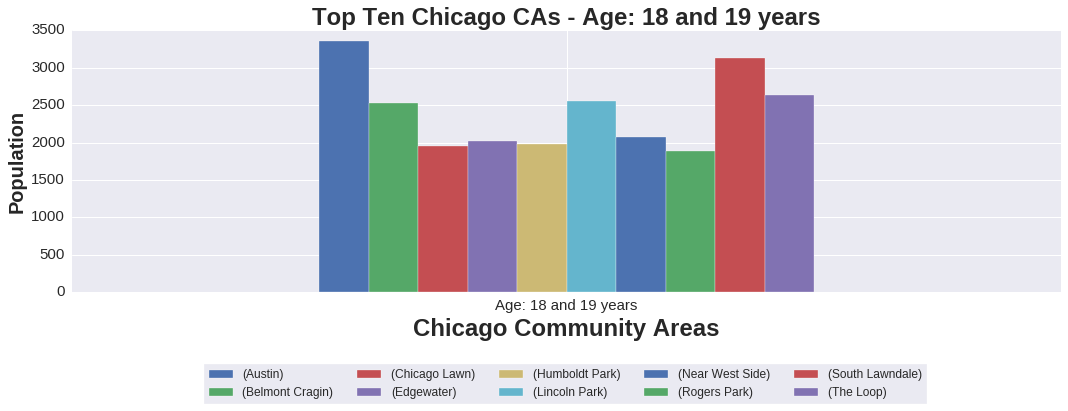

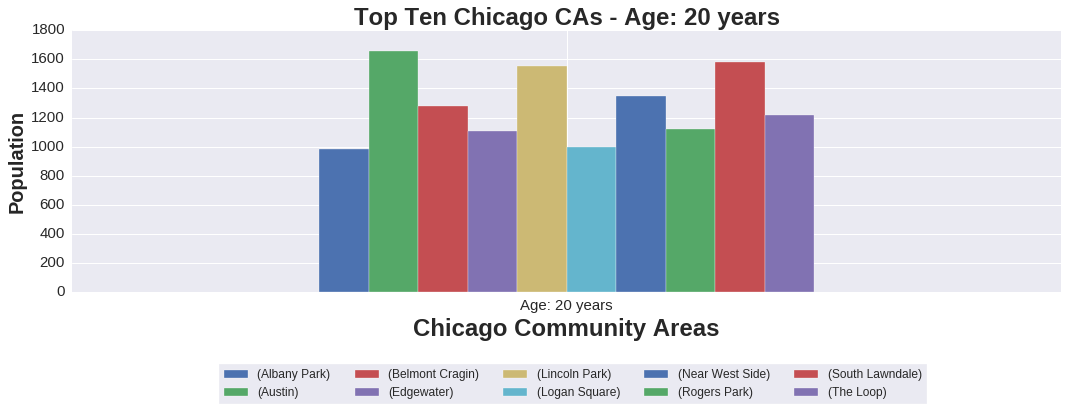

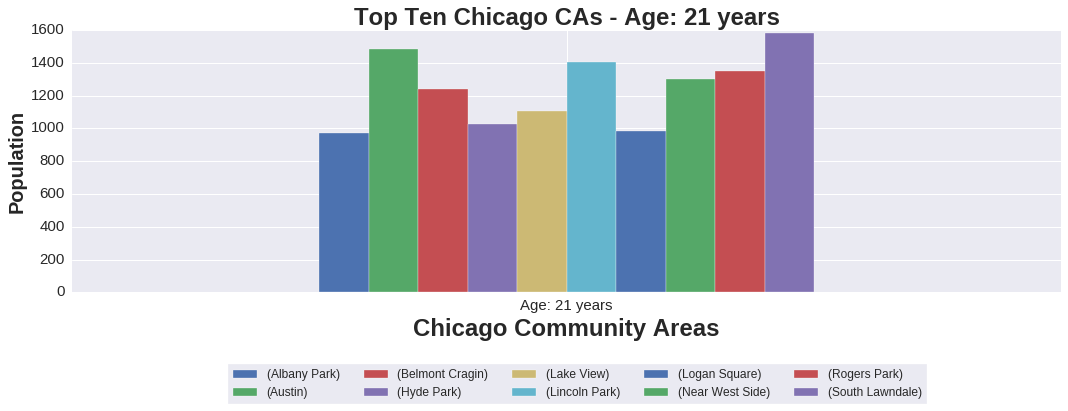

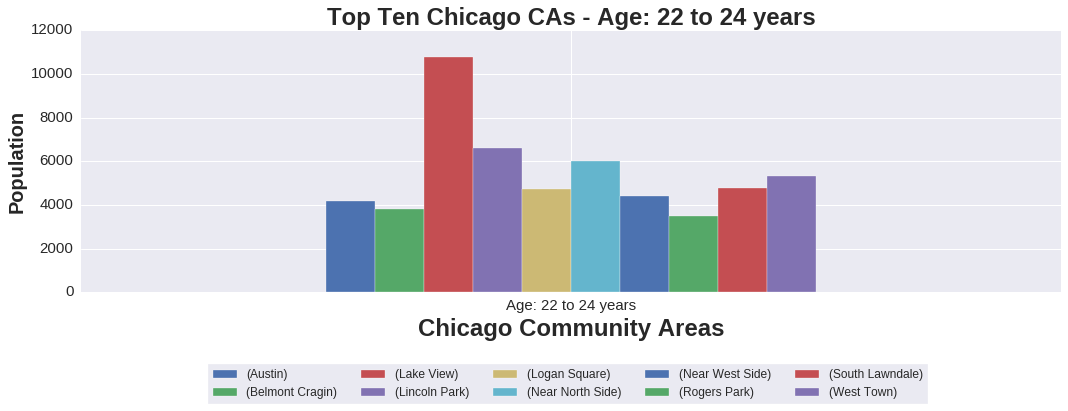

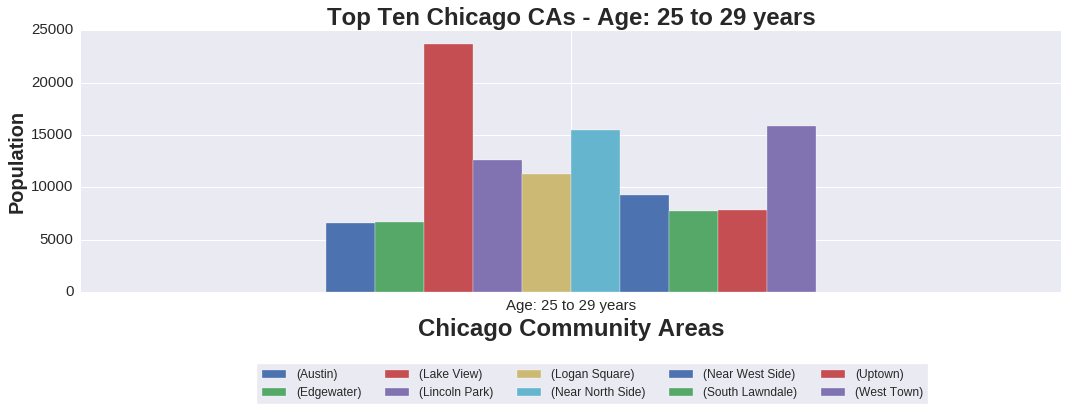

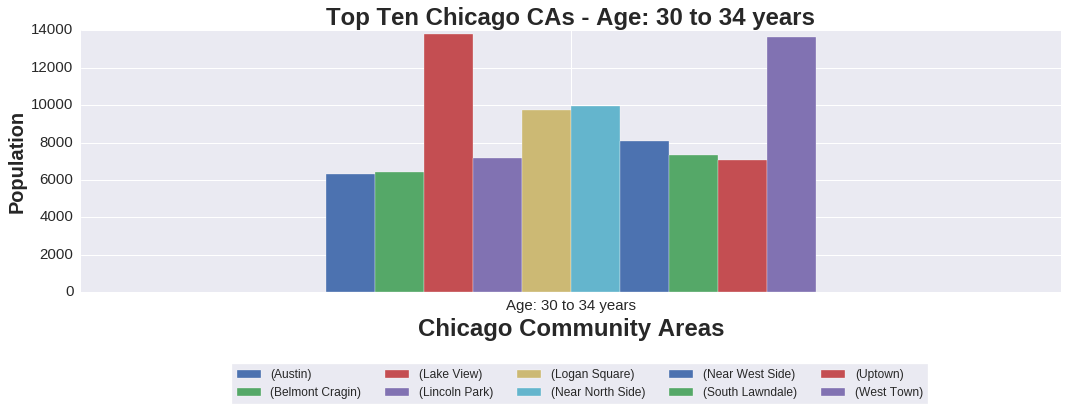

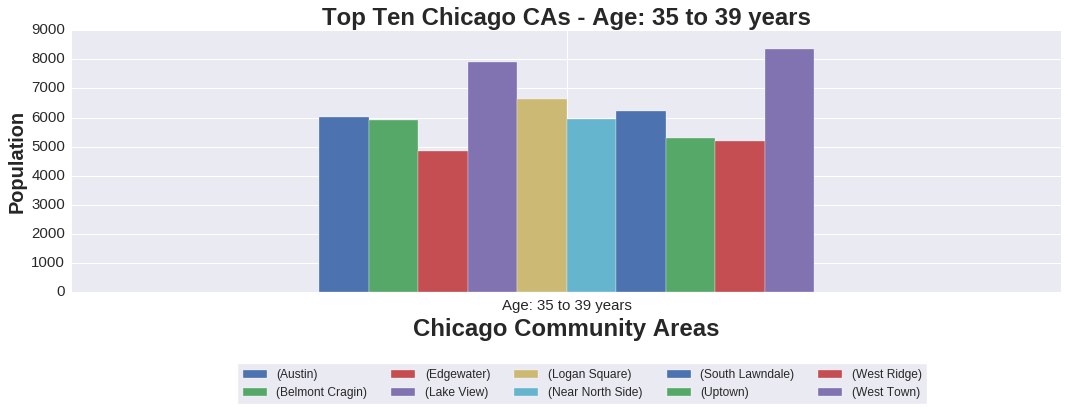

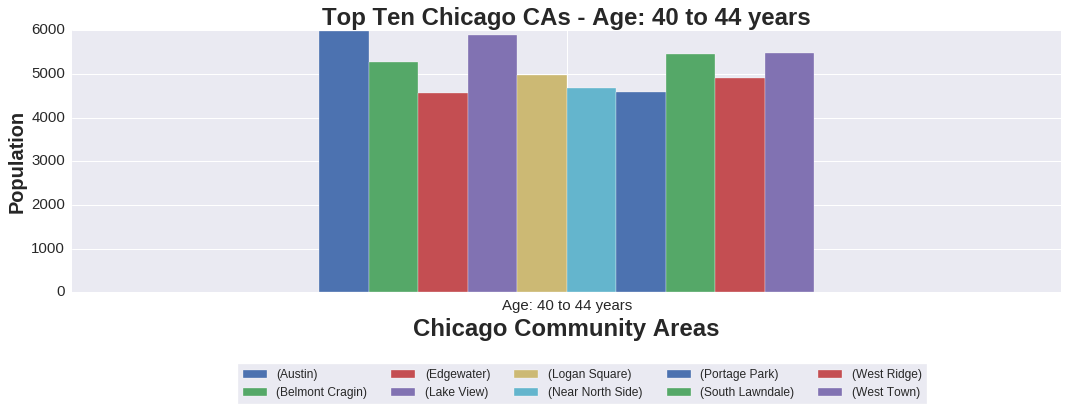

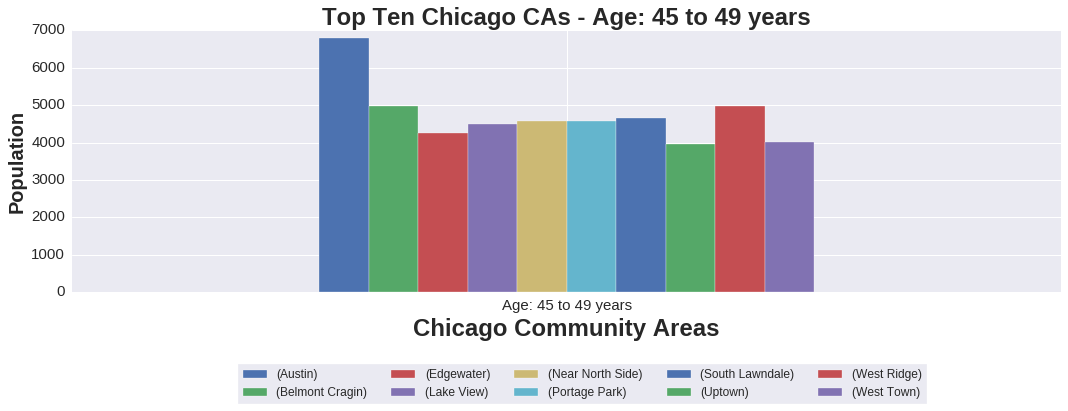

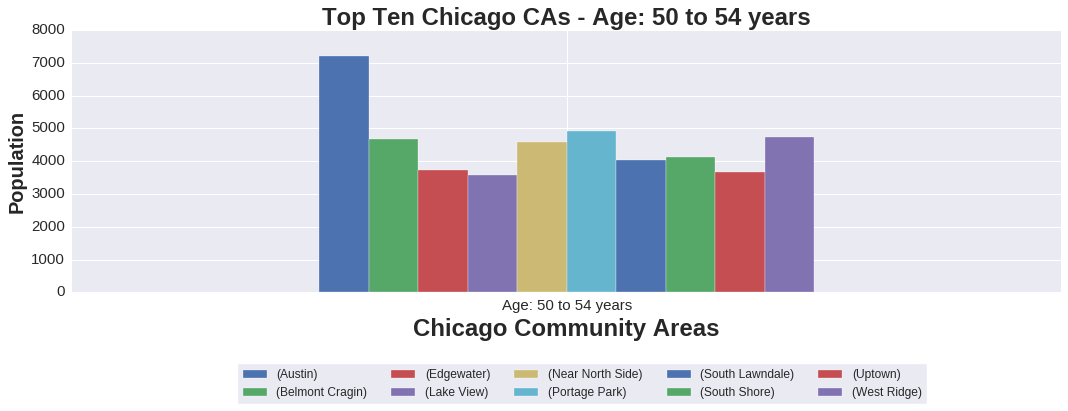

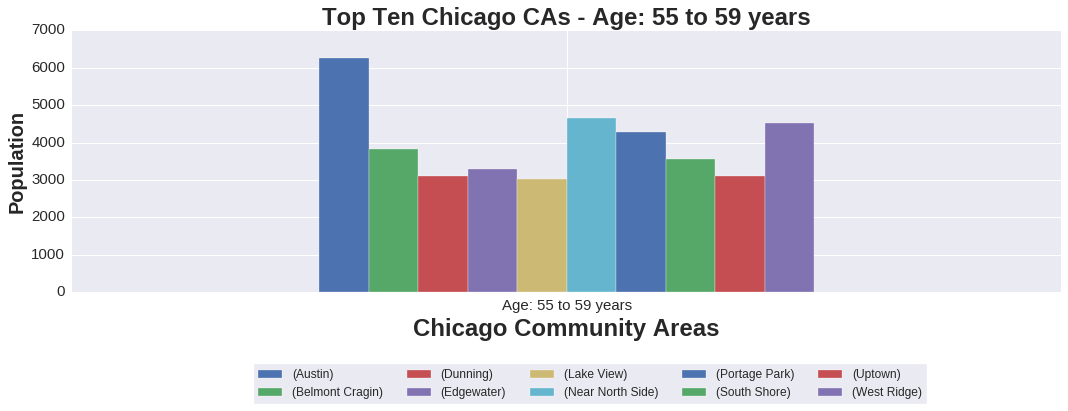

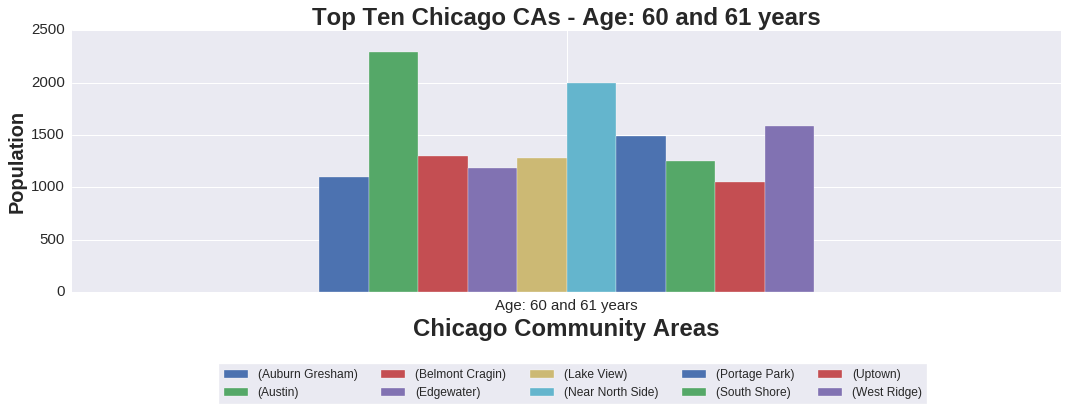

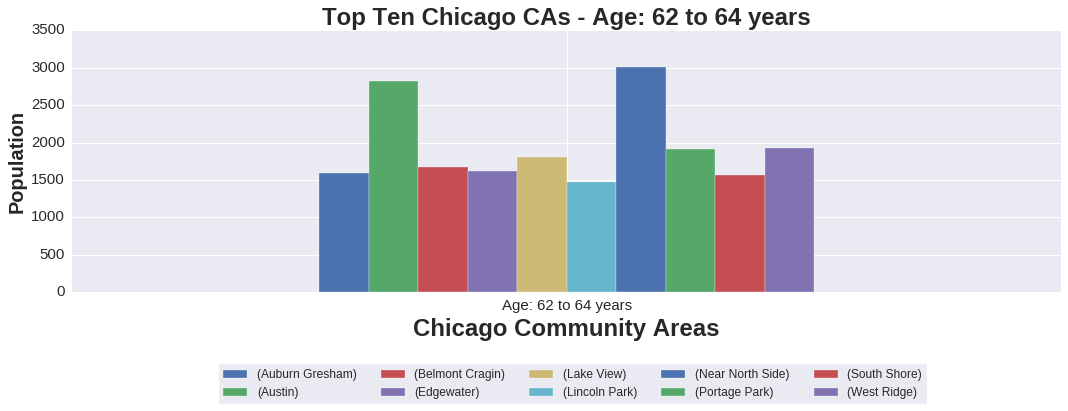

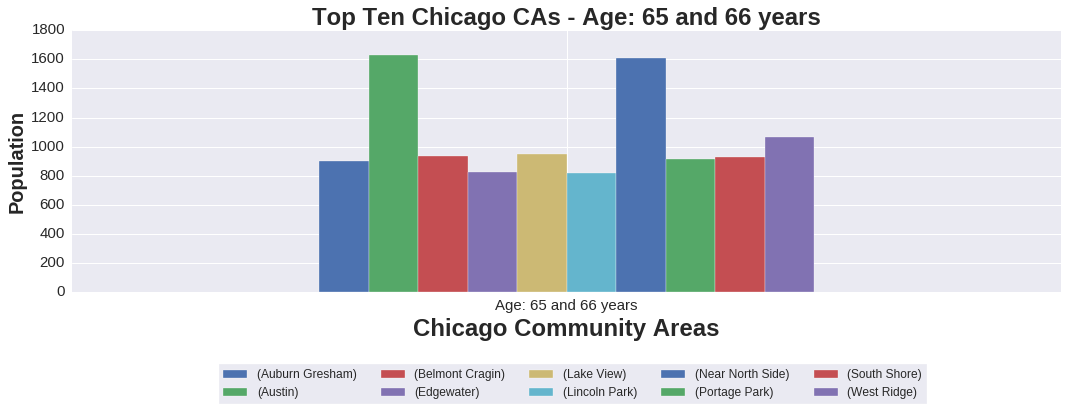

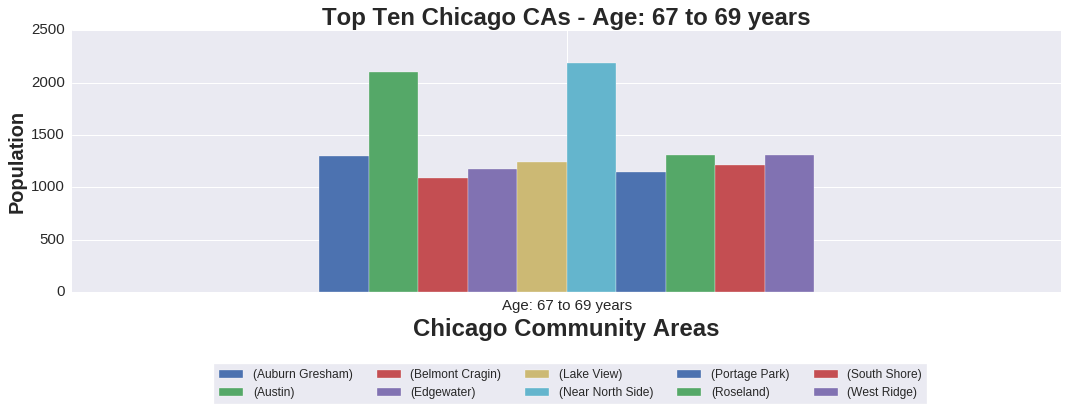

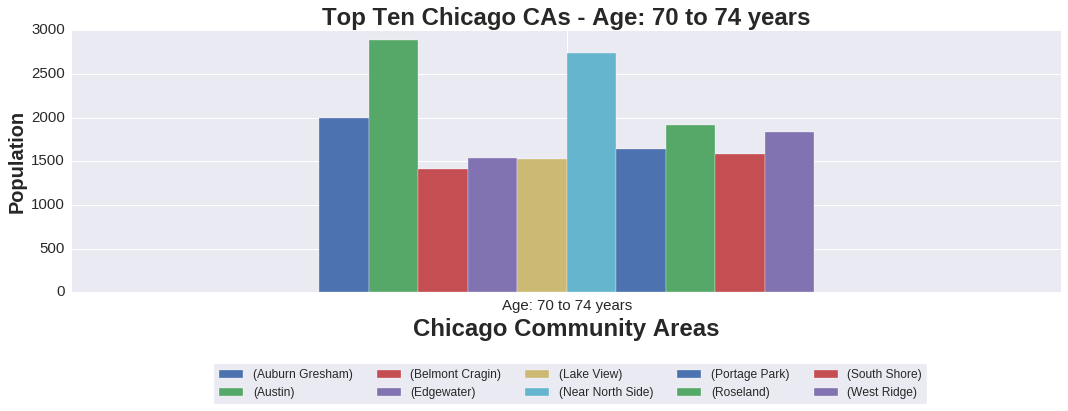

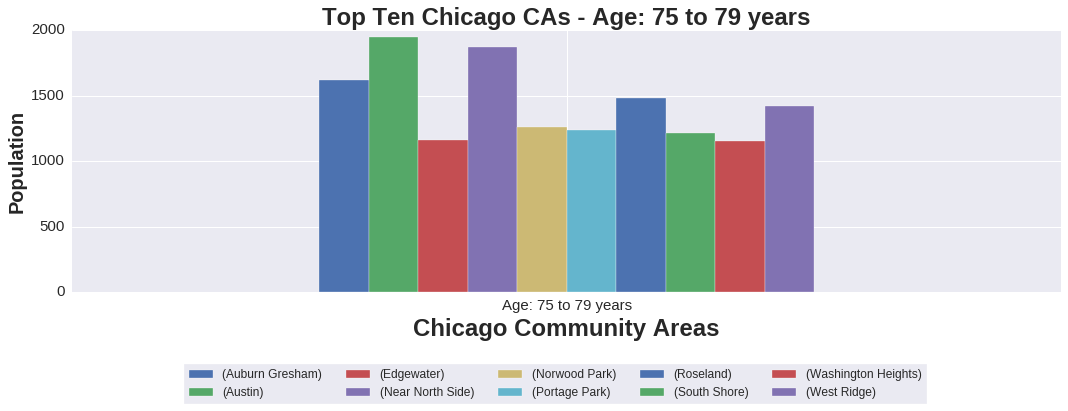

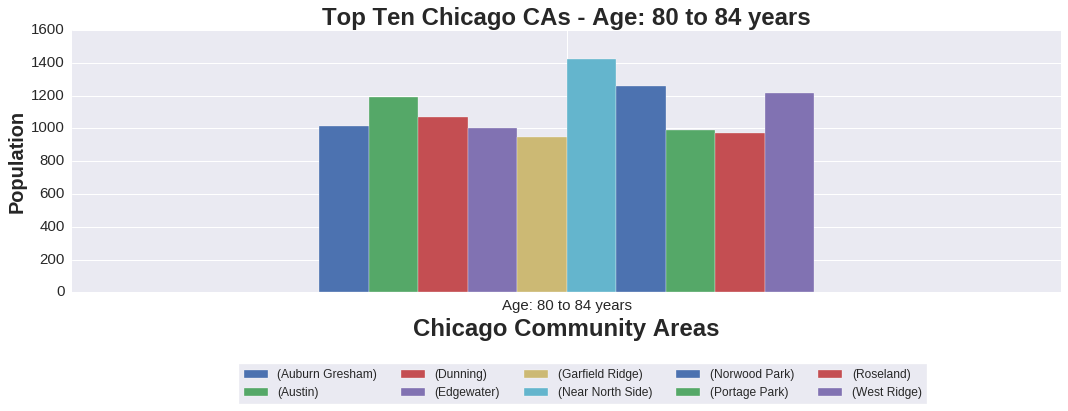

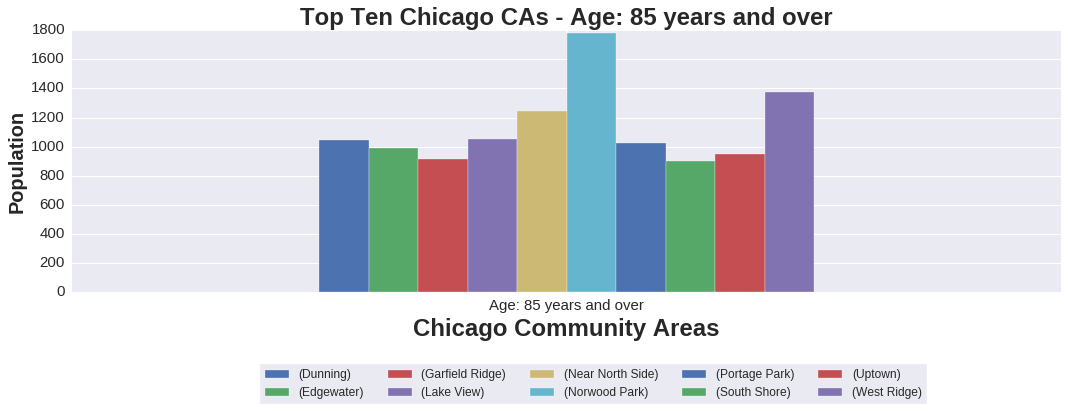

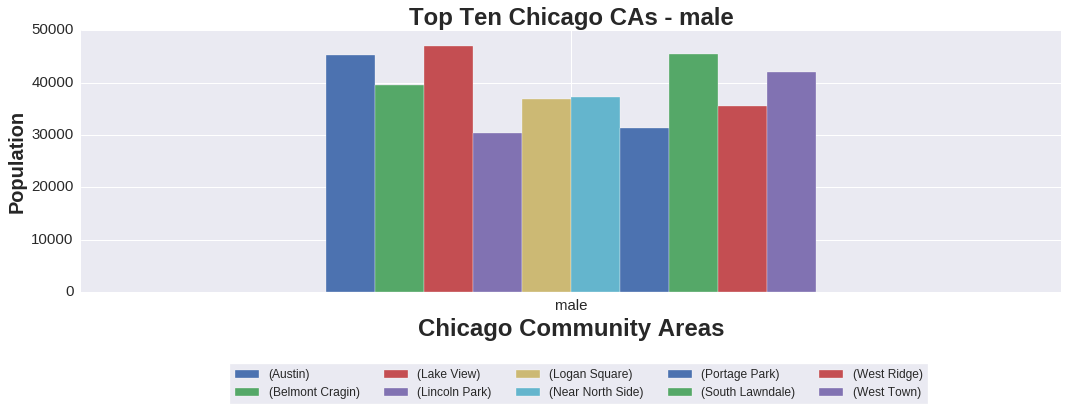

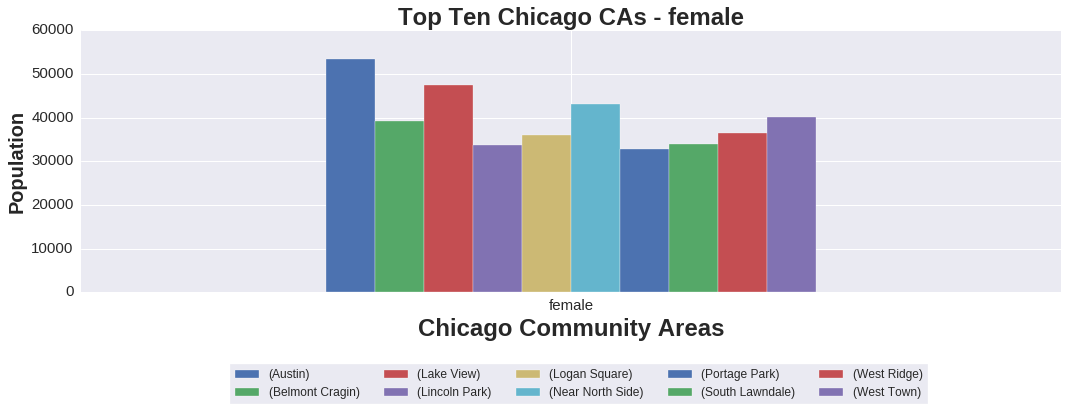

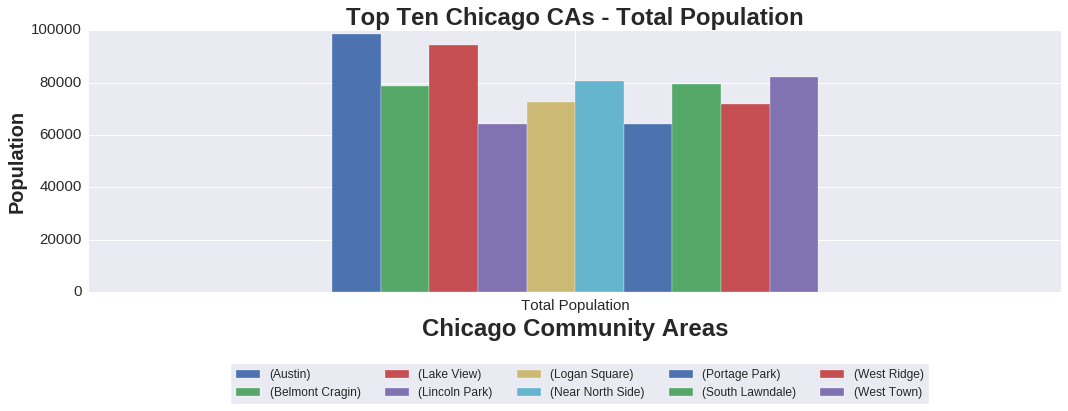

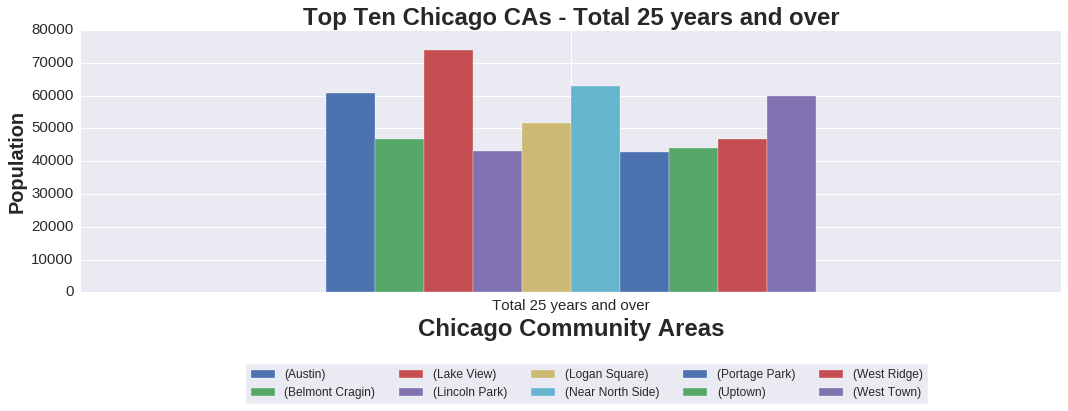

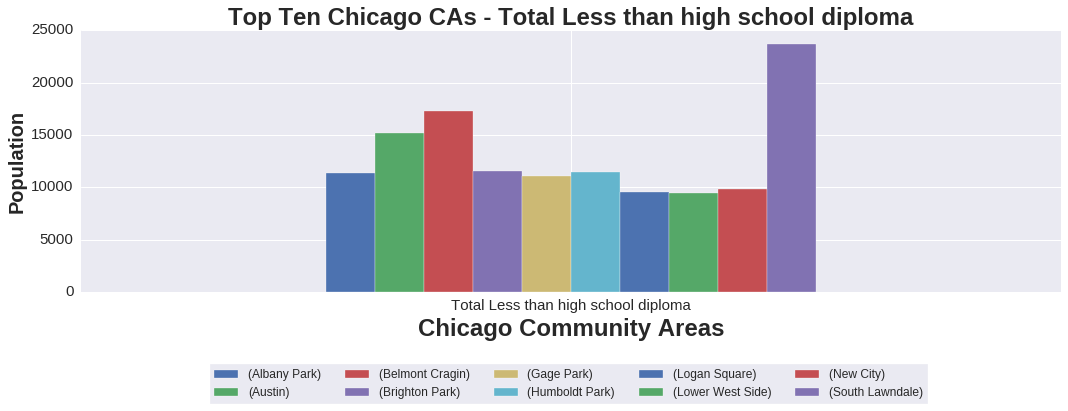

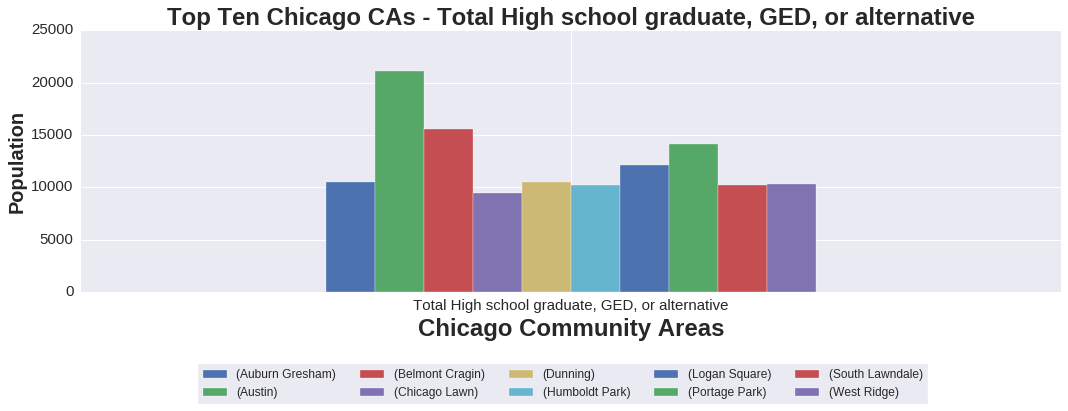

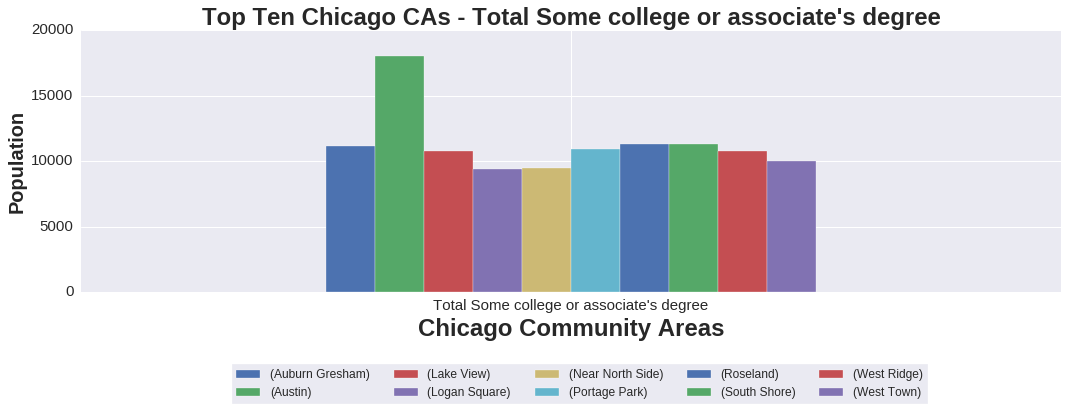

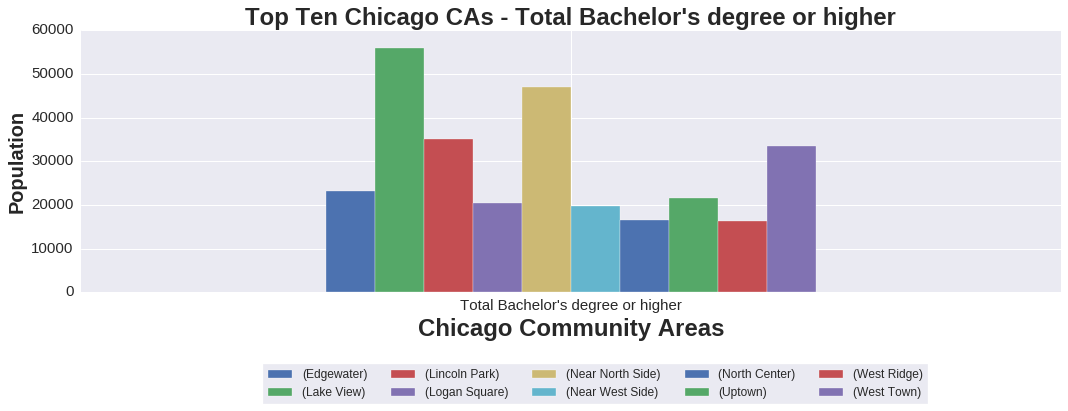

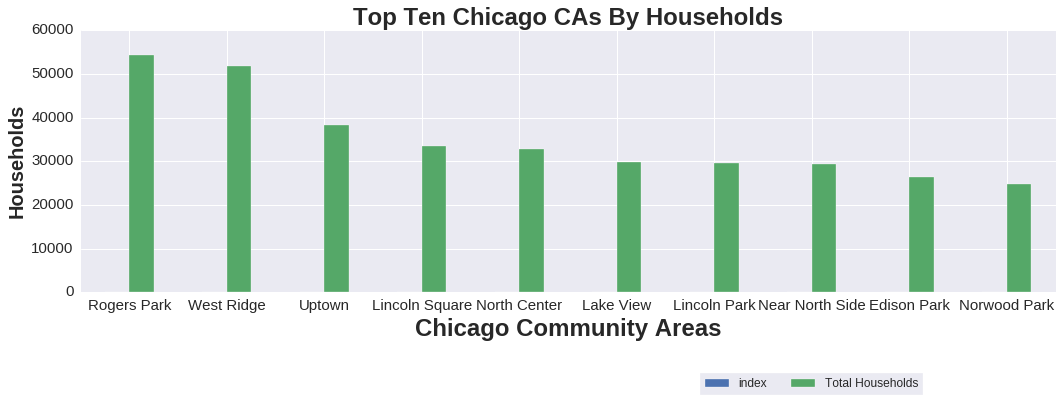

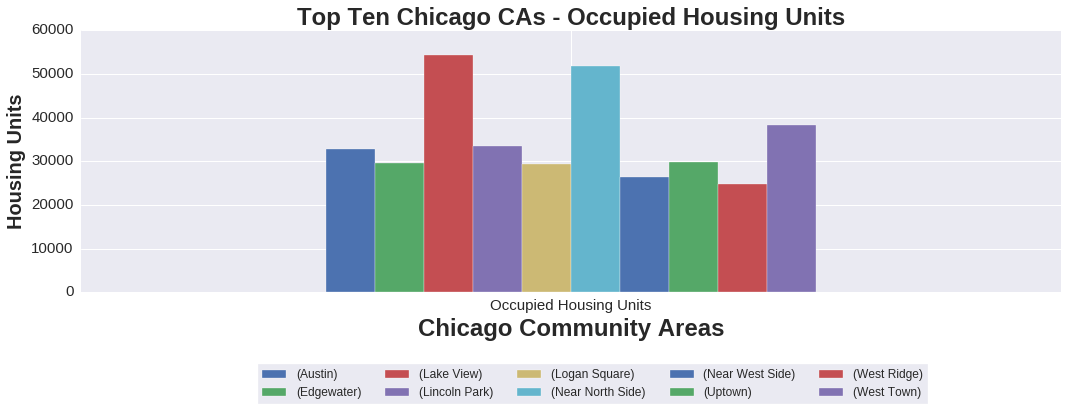

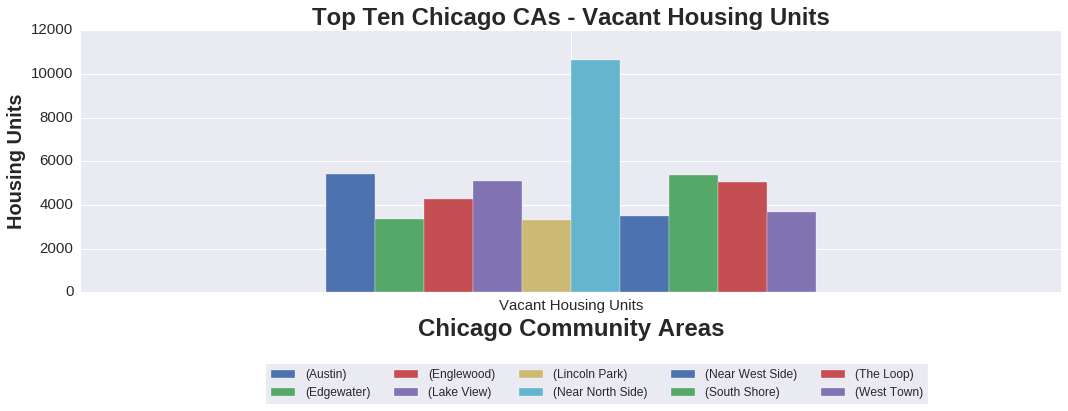

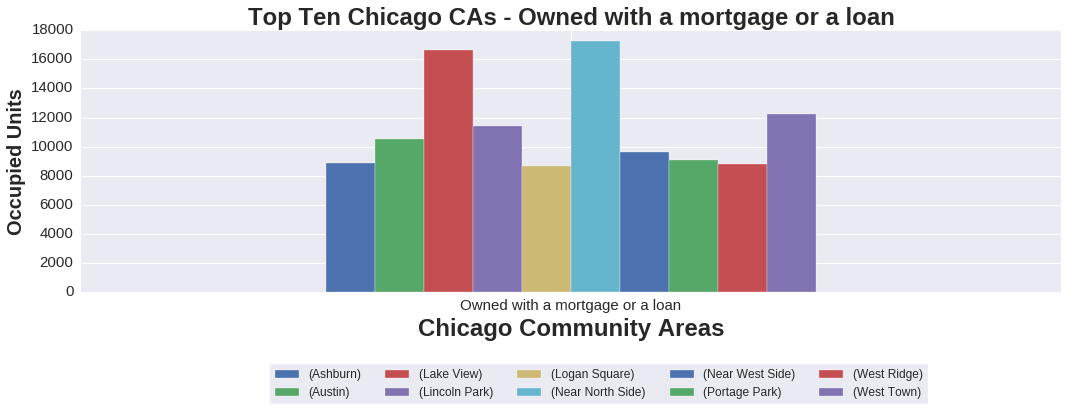

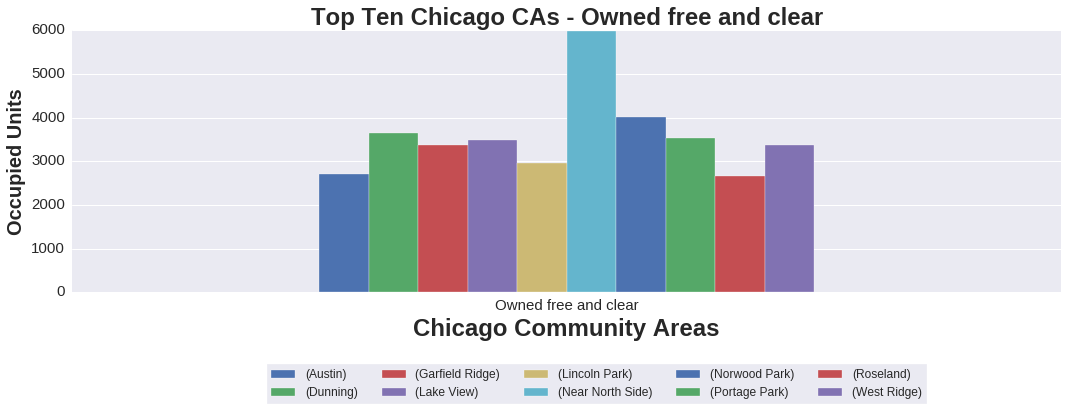

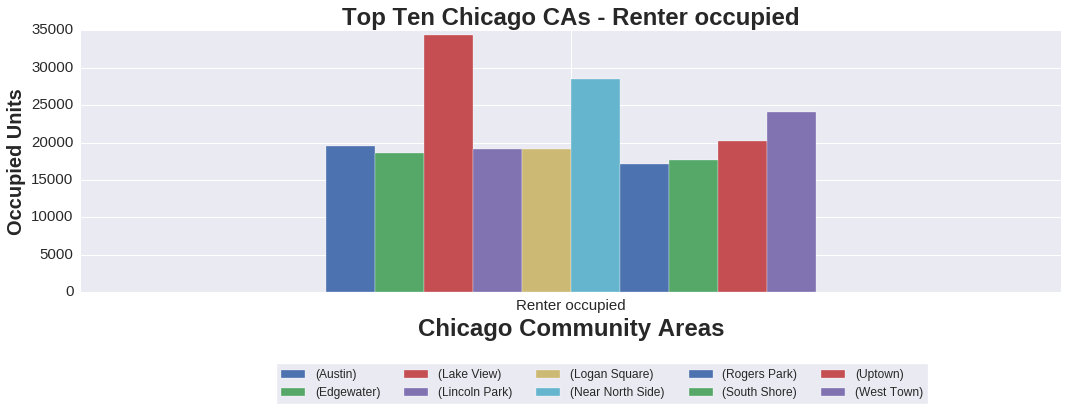

In [6]:
seaborn.set()
    
def graphing_fct():
    def runplot(pvtdf, ytitle, main_title):    
        
        fig = pvtdf.plot(kind='bar', edgecolor='w',figsize=(15,5), width=0.5, fontsize = 10)
        locs, labels = plt.xticks()    
        plt.title(main_title, weight='bold', size=24)
        lgd = plt.legend(loc='right', ncol=5, frameon=True, shadow=False, prop={'size': 12},
                         bbox_to_anchor=(0.87, -0.35))

        for i in range(len(lgd.get_texts())):        
            txt = lgd.get_texts()[i].get_text().replace('(Population, ', '(').replace('(Housing_Units, ', '(')
            lgd.get_texts()[i].set_text(txt)
    
        plt.xlabel('Chicago Community Areas', weight='bold', size=24)
        plt.ylabel(ytitle, weight='bold', size=20)
        plt.tick_params(axis='x', bottom='off', top='off', labelsize=15)
        plt.tick_params(axis='y', left='off', right='off', labelsize=15)
            
        plt.grid(b=True)
        plt.setp(labels, rotation=0, rotation_mode="anchor", ha="center")
        plt.tight_layout()
        plt.show()
        plt.clf()
        
        return fig            
        
    plot_list = []
    # COMM AREA
    grp_df = census_df['Total Population'].nlargest(10)\
                  .to_frame().reset_index().rename_axis(None)\
                  .join(census_df[['Geog']]).set_index('Geog')
                  
    plot_list.append(runplot(grp_df, 'Population', 'Top Ten Chicago CAs By Population'))
 
    # RACE
    for g in race_long_df['Race_Ethnicity'].unique():
        
        grp_df = race_long_df[race_long_df['Race_Ethnicity']==g].groupby(['Race_Ethnicity'])['Population'].nlargest(10)\
                      .to_frame().reset_index().set_index('level_1').rename_axis(None)\
                      .join(race_long_df[['Geog']])\
                      .pivot_table(index=['Race_Ethnicity'], columns=['Geog'], values=['Population'])
    
        plot_list.append(runplot(grp_df, 'Population', 'Top Ten Chicago CAs - {}'.format(g.replace('Not Hispanic or Latino,', ''))))
    
    

    # AGE
    for g in age_long_df['Age_Group'].unique():
        
        grp_df = age_long_df[age_long_df['Age_Group']==g].groupby(['Age_Group'])['Population'].nlargest(10)\
                      .to_frame().reset_index().set_index('level_1').rename_axis(None)\
                      .join(age_long_df[['Geog']])\
                      .pivot_table(index=['Age_Group'], columns=['Geog'], values=['Population'])
    
        plot_list.append(runplot(grp_df, 'Population', 'Top Ten Chicago CAs - {}'.format(g)))
    
    plt.close()

    # GENDER
    for g in gender_long_df['Gender'].unique():
        
        grp_df = gender_long_df[gender_long_df['Gender']==g].groupby(['Gender'])['Population'].nlargest(10)\
                      .to_frame().reset_index().set_index('level_1').rename_axis(None)\
                      .join(gender_long_df[['Geog']])\
                      .pivot_table(index=['Gender'], columns=['Geog'], values=['Population'])
    
        plot_list.append(runplot(grp_df, 'Population', 'Top Ten Chicago CAs - {}'.format(g)))
    
    plt.close()

    # EDUCATION
    for g in educ_long_df['Education_Level'].unique():
        
        grp_df = educ_long_df[educ_long_df['Education_Level']==g].groupby(['Education_Level'])['Population'].nlargest(10)\
                      .to_frame().reset_index().set_index('level_1').rename_axis(None)\
                      .join(educ_long_df[['Geog']])\
                      .pivot_table(index=['Education_Level'], columns=['Geog'], values=['Population'])
    
        plot_list.append(runplot(grp_df, 'Population', 'Top Ten Chicago CAs - {}'.format(g)))
    
    plt.close()

    # HOUSEHOLDS
    grp_df = hholds_long_df['Total Households'].nlargest(10)\
                  .to_frame().reset_index().rename_axis(None)\
                  .join(hholds_long_df[['Geog']]).set_index('Geog')
                  
    runplot(grp_df, 'Households', 'Top Ten Chicago CAs By Households')

    # HOUSING
    for g in housing_long_df['Occupied_Status'].unique():
        
        grp_df = housing_long_df[housing_long_df['Occupied_Status']==g].groupby(['Occupied_Status'])['Housing_Units'].nlargest(10)\
                      .to_frame().reset_index().set_index('level_1').rename_axis(None)\
                      .join(housing_long_df[['Geog']])\
                      .pivot_table(index=['Occupied_Status'], columns=['Geog'], values=['Housing_Units'])
    
        plot_list.append(runplot(grp_df, 'Housing Units', 'Top Ten Chicago CAs - {}'.format(g)))
    
    plt.close()


    # OCCUPIED
    for g in occupied_long_df['Occupied_Type'].unique():
        
        grp_df = occupied_long_df[occupied_long_df['Occupied_Type']==g].groupby(['Occupied_Type'])['Housing_Units'].nlargest(10)\
                      .to_frame().reset_index().set_index('level_1').rename_axis(None)\
                      .join(occupied_long_df[['Geog']])\
                      .pivot_table(index=['Occupied_Type'], columns=['Geog'], values=['Housing_Units'])
    
        plot_list.append(runplot(grp_df, 'Occupied Units', 'Top Ten Chicago CAs - {}'.format(g)))
    
    plt.close()

    return plot_list


graphing_fct()

## Timeit Benchmark

In [ ]:
from contextlib import contextmanager

# USED TO SUPPRESS CONSOLE OUTPUT
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            
reshape_times = []; extract_times = []; summarize_times = []; graphing_times = []

with suppress_stdout():
    for i in range(100):
        reshape_times.append(round(timeit.timeit('extract_fct()', globals=globals(), number=1), 5))
        extract_times.append(round(timeit.timeit('reshape_fct()', globals=globals(),number=1), 5))
        summarize_times.append(round(timeit.timeit('summarize_fct()', globals=globals(), number=1), 5))
        graphing_times.append(round(timeit.timeit('graphing_fct()', globals=globals(), number=1), 5))
        
    
benchmark_df = pd.DataFrame({'reshape': reshape_times,
                             'extract': extract_times,
                             'summarize': summarize_times})
    
benchmark_df.agg(['mean', 'median', 'min', 'max', 'sum']).T


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [4]:
benchmark_df = pd.read_csv('CHI_CommAreas_PandasBenchmark.csv', index_col=0)

benchmark_df.describe()

,extract,graphing,reshape,summarize
count,100.000,100.000,100.000,100.000
mean,0.026,8.284,0.006,0.020
std,0.004,0.461,0.001,0.004
min,0.022,7.397,0.005,0.017
25%,0.023,8.024,0.006,0.018
50%,0.025,8.304,0.006,0.019
75%,0.026,8.493,0.007,0.021
max,0.042,9.413,0.014,0.039


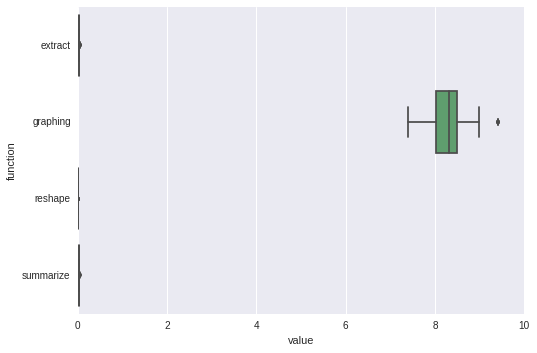

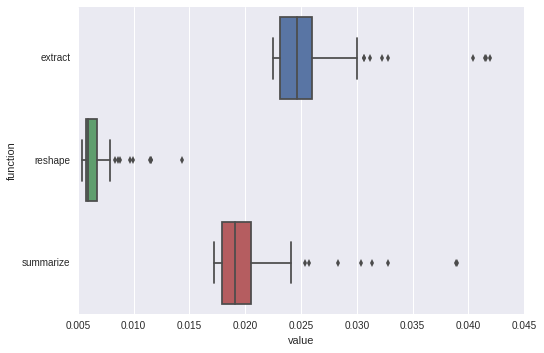

In [17]:
seaborn.boxplot(x='value', y='function', data=benchmark_df.melt(var_name=['function']))
plt.show()

seaborn.boxplot(x='value', y='function', data=benchmark_df.drop(['graphing'], axis=1).melt(var_name=['function']))
plt.show()


In [ ]:
plt.clf()
plt.close()